<a href="https://colab.research.google.com/github/neelakshij/Cough_Analysis/blob/main/EDA_coughvid_with_Severity_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset:
The COUGHVID crowdsourcing dataset, a corpus for the study of large-scale cough analysis algorithms. Sci Data 8, 156 (2021).
authors: Orlandic, L., Teijeiro, T. & Atienza, D.
https://doi.org/10.1038/s41597-021-00937-4

Coughvid dataset has been preprocessed and respective cleaned_dataset file has been provided by Dharvi. Find notebook at following link.
Ref: https://github.com/CodeItD5/Cough-Severity-Prediction/blob/main/COUGHVID-DATASET-ANALYSIS.ipynb

Let's consider only those audios that are labeled with cough severity prediction for EDA.

In [45]:
import os
from google.colab import drive

MOUNTPOINT = "/content/gdrive"
DATADIR = os.path.join(MOUNTPOINT, "MyDrive")
drive.mount(MOUNTPOINT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [46]:
# import libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import subprocess
from pathlib import Path
from scipy.stats import kurtosis, skew

In [47]:
# import cleaned data file and check severity column
df_cleaned_for_severityPrediction = pd.read_csv('/content/gdrive/MyDrive/omdenaLC-CoughSeverityDetection/cleaned_coughvid_data.csv')
print(df_cleaned_for_severityPrediction.shape)
df_cleaned_for_severityPrediction['severity'].value_counts()

(2587, 17)


mild           1691
pseudocough     526
severe          230
unknown         138
Name: severity, dtype: int64

In [48]:
# drop records where severity==unknown
df_severity_notnull = df_cleaned_for_severityPrediction[df_cleaned_for_severityPrediction.severity != 'unknown']
print(df_severity_notnull.shape)
df_severity_notnull['severity'].value_counts()

(2449, 17)


mild           1691
pseudocough     526
severe          230
Name: severity, dtype: int64

In [16]:
df_severity_notnull.tail()

,uuid,cough_detected,age,gender,respiratory_condition,fever_muscle_pain,status,status_SSL,cough_type,dyspnea,wheezing,stridor,choking,congestion,nothing,diagnosis,severity
2582,fed255ec-4829-4f4a-b22d-9bb23f2dd89f,0.9502,NaN,NaN,NaN,NaN,NaN,COVID-19,dry,False,False,False,False,False,True,upper_infection,mild
2583,ff1234d7-7837-4ba7-842f-99fdc916baa9,0.9947,29.0,male,False,True,symptomatic,NaN,dry,False,False,False,False,False,True,upper_infection,mild
2584,ff8363d2-016d-4738-9499-4c62480886fb,0.9933,NaN,female,False,False,COVID-19,NaN,dry,False,False,False,False,False,True,COVID-19,mild
2585,ffd18a56-096d-40fc-9862-e5c5a8ca1fcd,0.9953,25.0,female,False,False,healthy,healthy,dry,False,False,False,False,False,True,COVID-19,mild
2586,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,0.9498,23.0,male,False,False,healthy,healthy,dry,False,False,False,False,False,True,healthy_cough,pseudocough


get information about data. info() function lists column names along with notnull value count and data type.

Dtype informs how many variables are categorical (object & bool), numerical (float). This dataset has total 15 categorical and 2 numerical variables.

Non-Null count informs out of 2449 records how many records are useful for further analysis. All boolean, one categorical (uuid) and one nuerical (cough_detected) variables have all not-null values. "uuid" are unique ids and we have selected cough_detected>0.8 for this dataset. Though previously, we have removed nan and unknown labeled records from data, severity column still has 2 records of null values, Out of 2449 records, 2447 are not null records.

In [18]:
df_severity_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2449 entries, 0 to 2586
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   2449 non-null   object 
 1   cough_detected         2449 non-null   float64
 2   age                    2063 non-null   float64
 3   gender                 2194 non-null   object 
 4   respiratory_condition  2194 non-null   object 
 5   fever_muscle_pain      2194 non-null   object 
 6   status                 2194 non-null   object 
 7   status_SSL             1024 non-null   object 
 8   cough_type             2449 non-null   object 
 9   dyspnea                2449 non-null   bool   
 10  wheezing               2449 non-null   bool   
 11  stridor                2449 non-null   bool   
 12  choking                2449 non-null   bool   
 13  congestion             2449 non-null   bool   
 14  nothing                2449 non-null   bool   
 15  diag

In [19]:
# calculate the percentage of missing values in each column.

(df_severity_notnull.isnull().sum()/(len(df_severity_notnull)))*100

uuid                      0.000000
cough_detected            0.000000
age                      15.761535
gender                   10.412413
respiratory_condition    10.412413
fever_muscle_pain        10.412413
status                   10.412413
status_SSL               58.187015
cough_type                0.000000
dyspnea                   0.000000
wheezing                  0.000000
stridor                   0.000000
choking                   0.000000
congestion                0.000000
nothing                   0.000000
diagnosis                 0.000000
severity                  0.081666
dtype: float64

Among two numerical variables, cough_detected ia always True as on that condition we have current subset. Another numerical variable is age which is not going to affect our prediction label, i.e., severity of cough.

Now among shown 9 categorical variables, one is our prediction label. Rest 8 variables are:
'uuid', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status', 'status_SSL', 'cough_type', 'diagnosis'.
uuid is unique and gender won't bias our label.
Other 5 variables are important to explore, except status_SSL which has 58% null values.
Though haven't shown here boolean variables are also important.

In [20]:
# how many Numerical and categorical variables this data have
cat_cols=df_severity_notnull.select_dtypes(include=['object']).columns
num_cols = df_severity_notnull.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index(['uuid', 'gender', 'respiratory_condition', 'fever_muscle_pain',
       'status', 'status_SSL', 'cough_type', 'diagnosis', 'severity'],
      dtype='object')
Numerical Variables:
['cough_detected', 'age']


In [49]:
# let's create the subset of this dataset including useful columns.
subset = df_severity_notnull.loc[:,['respiratory_condition', 'fever_muscle_pain',
       'status', 'cough_type','dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'diagnosis', 'severity']]
print(subset.shape)
subset.head()

(2449, 11)


,respiratory_condition,fever_muscle_pain,status,cough_type,dyspnea,wheezing,stridor,choking,congestion,diagnosis,severity
0,NaN,NaN,NaN,dry,False,False,False,True,False,COVID-19,mild
1,NaN,NaN,NaN,wet,False,False,False,False,False,lower_infection,mild
2,False,False,symptomatic,dry,False,False,False,False,False,healthy_cough,pseudocough
3,True,False,COVID-19,dry,False,False,False,False,False,healthy_cough,pseudocough
4,False,False,healthy,dry,False,False,False,False,False,COVID-19,mild


In [28]:
subset.describe()

,respiratory_condition,fever_muscle_pain,status,cough_type,dyspnea,wheezing,stridor,choking,congestion,diagnosis,severity
count,2194,2194,2194,2449,2449,2449,2449,2449,2449,2449,2447
unique,2,2,3,3,2,2,2,2,2,5,3
top,False,False,symptomatic,dry,False,False,False,False,False,upper_infection,mild
freq,1619,1759,909,1648,2358,2321,2417,2430,2339,695,1691


From the discription of subset, as shown in above cell,
* we know how many non-null records are
* how many unique values each column has
* which value occured frequently as top and its count as freq.

             dyspnea  wheezing   stridor   choking  congestion
dyspnea     1.000000  0.118760  0.205516  0.031838    0.009512
wheezing    0.118760  1.000000 -0.027021  0.083788   -0.024353
stridor     0.205516 -0.027021  1.000000 -0.010174   -0.007592
choking     0.031838  0.083788 -0.010174  1.000000   -0.019176
congestion  0.009512 -0.024353 -0.007592 -0.019176    1.000000


<Axes: >

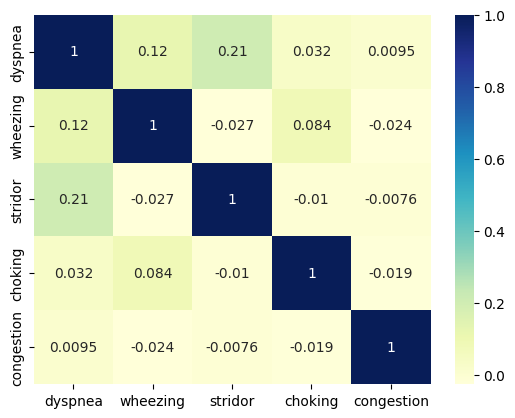

In [34]:
# calculate the correlation matrix on the numeric columns
correlation = subset.corr()

print(correlation)

# plotting correlation heatmap
sns.heatmap(correlation, cmap="YlGnBu", annot=True)

Pairwise correlation have shown for "dyspnea, wheezing, stridor, choking and congestion".
Most of these variables are not or poorly correlated.
Only choking and wheezing are highly correlated (0.84).

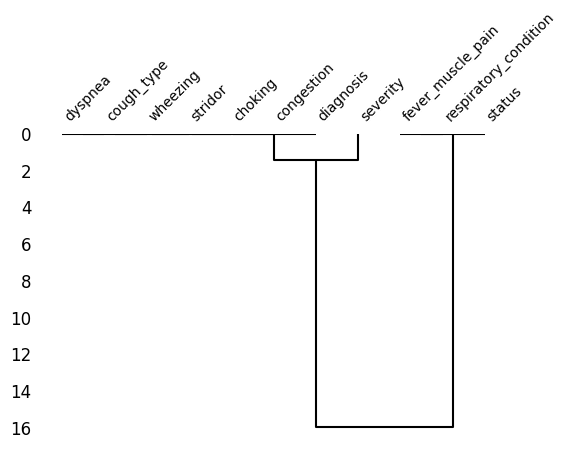

In [44]:
# Dendrogram reveals correlation between all variable as a tree diagram, a hierarchical clustering algorithm.
import missingno as msno
msno.dendrogram(subset, figsize=(6,4), fontsize=10);

Dendogram represents the similarity relationships among a group of
entities. Vetical orientation (Y-axis) represents the clossness (similarity) within attributes or the clusters. Greater the y-axis value, i.e., height, larger the difference within the leafs that are on horizontal orientation (x-axis).

We can see clearly two simplicifolious clusters. Simplicifolious means single leafed.

The first cluster contains attributes from dyspnea till diagnosis, are close together (similar to each other), as y-axis is zero. The second cluster helds fever_muscle_pain till status at zeroth level. First cluster closer (at level 2) to prediction label than latter one (at level 16). Attributes in the cluster 1 are less similar than the attributes in the cluster 2.

{Ref: https://wheatoncollege.edu/wp-content/uploads/2012/08/How-to-Read-a-Dendrogram-Web-Ready.pdf}

In [50]:
# Now following cluster grouping, let' findout correlation between diagnosis and severity
# Cross tabulation between diagnosis and severity
CrosstabResult=pd.crosstab(index=subset['diagnosis'],columns=subset['severity'])
print(CrosstabResult)

severity             mild  pseudocough  severe
diagnosis                                     
COVID-19              439            0      58
healthy_cough           6          517       0
lower_infection       466            0      93
obstructive_disease   134            0      40
upper_infection       646            9      39


In [51]:
from scipy.stats import chi2_contingency

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value = the Probability of null hypothesis H0, where H0 = variables are NOT correlated to each other.
# If P-Value > 0.05 then only H0 is True

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.0


In [52]:
# Now following cluster grouping, let' findout correlation between respiratory_condition and severity
# Cross tabulation between diagnosis and severity
CrosstabResult1=pd.crosstab(index=subset['respiratory_condition'],columns=subset['severity'])
print(CrosstabResult1)

severity               mild  pseudocough  severe
respiratory_condition                           
False                  1123          342     153
True                    389          122      63


In [53]:
from scipy.stats import chi2_contingency

# Performing Chi-sq test
ChiSqResult1 = chi2_contingency(CrosstabResult1)

# P-Value = the Probability of null hypothesis H0, where H0 = variables are NOT correlated to each other.
# If P-Value > 0.05 then only H0 is True

print('The P-Value of the ChiSq Test is:', ChiSqResult1[1])

The P-Value of the ChiSq Test is: 0.5598952662841431


Above chi square test results: ChiSqResult1 with p value> 0.5 confirms the dissimilarity between one of the cluster 2 attribute, respiratory_condition and severity. Whereas diagnosis, one onf the attribute from the cluster 1 is correlated (more similarity) to attribute severity as p value < 0.5.

When variables are correlated, tracking change or behavior of one of the correlated variable, we may observe similar change or behaviour in other correlated variables.
if variables are highly correlated then advise is to retain only one of them.